# C-MAPSS Aircraft Engine Simulator Dataset

En los últimos años, dentro del campo de la Gestión de Activos Físicos, diversas investigaciones han propuesto la utilización de modelos de deep learning cada vez más sofisticados para la estimación y predicción del tiempo de vida remanente (RUL) de equipos y/o componentes particulares. El tiempo de vida remanente o Remaining Useful Life (RUL) consiste en una variable utilizada principalmente para describir la degradación temporal de un activo durante su operación y describe el tiempo de operación remanente del activo antes de que ocurra su falla. De este modo, mejores estimadores de esta variable resultan de suma importancia a la hora de gestionar e implementar mejores políticas de mantenimiento y operación.

En este workshop implementaremos un modelo recurrente mediante `tensorflow` y `keras` para la predicción del RUL de un turbofán de aviación, a partir de la serie temporal de mediciones de sus sensores.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_05/bin/nasa_logo.png" height="200"><img src="https://www.researchgate.net/profile/Xiaolei_Fang/publication/310789705/figure/fig2/AS:462413100261377@1487259282977/Simplified-diagram-of-engine-simulated-in-C-MAPSS-6.png" height="200">

El Comercial Modular Aero-Propulsion System Simulation (C-MAPSS) es un software desarrollado por NASA como ambiente de simulación de motores de reacción tipo turbofán. Así, esta herramienta permite la implementación y evaluación de algoritmos de control y diagnóstico sobre la operación de un motor turbofán de 90.000 lbf de propulsión.

En particular, el C-MAPSS dataset que utilizaremos en esta ocación consiste en múltiples simulaciones de degradación de motores turbofán bajo distintas condiciones, tanto mecánicas como operacionales. En este sentido, el dataset se compone de más de `27000` series temporales de los sensores del turbofán que, gracias a la simulación de este, han podido ser asociadas al RUL del motor.






## C-MAPSS Dataset

En esta sección nos encargaremos de cargar y explorar el dataset que utilizaremos, denominado `C-MAPSS FD001`, que contiene `100` simulaciones de motores mecánicamente distintos bajo condiciones nominales de operación. Nuevamente, para facilitar la carga del dataset a este entorno de Google Colab el achivo `CMAPSS_FD001.npz` ha sido cargado a un Google Drive.

In [5]:
!pip install -U -q PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# inicializar GoogleDrive con credenciales de autorización
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# crear carpeta para descargar los archivos .npz
!mkdir /content/datasets

# Google Drive IDs para descargar los archivos .npz
files_id = [('CMAPSS_FD001.npz', '1DNJFrQKB4I7SqjpFmM5SsKRaN7O9XCNZ')]

# comenzar descarga
print('descargando datasets: ', end='')

for filename, id in files_id:
  save_path = os.path.join('/content/datasets', filename)

  # descargar y guardar en /content/datasets
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(save_path)

# indicar descarga terminada
print('done')

descargando datasets: done


Carguemos este archivo mediante `np.load()` y exploremos las estructuras y datos que contiene.

In [6]:
import numpy as np

# cargar archivo CMAPSS_FD001.npz
dataset = np.load('/content/datasets/CMAPSS_FD001.npz', allow_pickle=True)

# print keys del dataset
print( list( dataset.keys() ) )

['x_train', 'y_train', 'x_test', 'y_test', 'image_format', 'allow_pickle']


También, como ya es rutinario, aprovecharemos de cargar el GitHub del curso deeplearningfallas para disponer de algunas utilidades que nos serán de utilidad más adelante.

In [7]:
# cargar GitHub https://github.com/cherrerab/deeplearningfallas.git
%cd /content/
!git clone https://github.com/cherrerab/deeplearningfallas.git
%cd /content/deeplearningfallas

/content
Cloning into 'deeplearningfallas'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 360 (delta 43), reused 0 (delta 0), pack-reused 249
Receiving objects: 100% (360/360), 37.16 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/content/deeplearningfallas


---
# Training Data

Podemos ver que el dataset ha sido previamente separado en conjuntos de `training` y `testing`. En particular, de acuerdo a la descripción de este dataset, cada uno de estos conjuntos están separados en `100` simulaciones de turbinas distintas. Luego, cada una de estas simulaciones contiene varias muestras de series temporales registradas durante la operación que están asociadas a un valor RUL en el conjunto `Y_train` o `Y_test`.

Para entender mejor esto, veamos un ejemplo a continuación.

In [8]:
# extraer conjuntos de training y testing del dataset
X_train, Y_train = dataset['x_train'], dataset['y_train']
X_test, Y_test = dataset['x_test'], dataset['y_test']

# print dimensiones de los conjuntos
print('X_train.shape: ', X_train.shape)
print('Y_train.shape: ', Y_train.shape)
print('\nX_test.shape: ', X_test.shape)
print('Y_test.shape: ', Y_test.shape)

# --
# podemos ver que cada uno de los conjuntos posee una forma (100,)
# donde cada uno de estos elementos corresponde a una
# simulación de CMAPSS distinta.

# ahora podemos extraer la series temporales de una de las
# simulaciones de la siguiente forma.
X_50 = X_train[50]
Y_50 = Y_train[50]

# print dimensiones de los datos de esta simulación
print('\nX_train[50].shape: ', X_50.shape)
print('Y_train[50].shape: ', Y_50.shape)


X_train.shape:  (100,)
Y_train.shape:  (100,)

X_test.shape:  (100,)
Y_test.shape:  (100,)

X_train[50].shape:  (184, 30, 14, 1)
Y_train[50].shape:  (184, 1)


De acuerdo a la descripción del dataset, y como se puede notar del resultado anterior, los datos de cada simulación en el conjunto `X_train` son de la forma `(n_samples, n_timesteps, n_features, 1)`. Donde en este caso `n_features` corresponde a la cantidad de sensores dentro de la simulación (`14`), mientras `n_timesteps` corresponde a la cantidad de puntos temporales o mediciones dentro de la serie (`30`). Por otro lado, los datos del conjunto `Y_train` son de la forma `(n_samples, 1)`, donde cada valor corresponde al RUL de las respectivas series temporales en el conjunto `X_train`.

Ahora, para generar los conjuntos `training` y `testing` que finalmente utilizaremos para desarrollar nuestros modelos, debemos concatenar las series de todas las simulaciones de `C-MAPSS` y modificar sus dimensiones para que sean compatibles con las capas y estructuras de `tensorflow` y `keras`.

In [9]:
# concatenar y reconfigurar datos de las 100 simulaciones CMAPSS

# los datos X deben ser de la forma (n_samples, n_timesteps, n_features)
X_train = np.vstack(X_train)
X_train = np.reshape(X_train, (-1, 30, 14))

X_test = np.vstack(X_test)
X_test = np.reshape(X_test, (-1, 30, 14))

# los datos Y deben ser de la forma (n_samples, 1)
Y_train = np.vstack(Y_train)
Y_train = np.reshape(Y_train, (-1, 1))

Y_test = np.vstack(Y_test)
Y_test = np.reshape(Y_test, (-1, 1))

# print dimensiones de los nuevos conjuntos
print('X_train.shape: ', X_train.shape)
print('Y_train.shape: ', Y_train.shape)
print('\nX_test.shape: ', X_test.shape)
print('Y_test.shape: ', Y_test.shape)

X_train.shape:  (17731, 30, 14)
Y_train.shape:  (17731, 1)

X_test.shape:  (10196, 30, 14)
Y_test.shape:  (10196, 1)


Como tenemos una gran cantidad de datos tanto en el conjunto de `training`, como en el de `testing`, siguiendo el procedimiento apropiado para el desarrollo de modelos de deep learning, utilizaremos la función `sklearn.train_test_split` para generar un conjunto de `validation`.

In [10]:
from sklearn.model_selection import train_test_split

# realizar data splitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  train_size=0.5, test_size=0.2,
                                                  random_state=0)

# print sample distribution
print( 'train split: {:d} samples'.format(X_train.shape[0]) )
print( '\nvalidation split: {:d} samples'.format(X_val.shape[0]) )

train split: 8865 samples

validation split: 3547 samples


Finalmente, para finalizar la exploración y procesamiento de los datos, podemos visualizar la información de una de las series temporales, separandola en cada uno de los sensores, para tener una mejor noción de los datos que estamos utilizando.

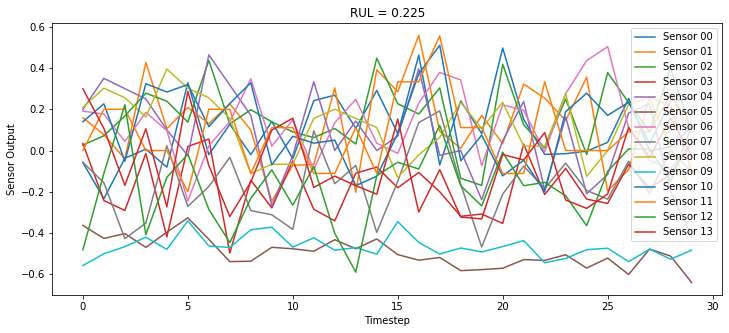

In [11]:
import matplotlib.pyplot as plt

# obtener serie temporal del conjunto train a visualizar
ts_24 = X_train[24, :, :]

# obtener RUL correspondiente
RUL = Y_train[24, 0]

# visualizar datos de los sensores
fig = plt.figure(figsize=(12, 5))

# para cada uno de los 14 sensores de la serie temporal
for s in range(14):
  sensor_ts = ts_24[:, s]
  # plotar respecto al tiempo
  legend = 'Sensor {:02d}'.format(s)
  plt.plot(np.arange(30), sensor_ts, label=legend)

# configurar resto del gráfico
plt.title('RUL = {:1.3f}'.format(RUL))
plt.ylabel('Sensor Output')
plt.xlabel('Timestep')

plt.legend()
plt.show()


---
# Model Building

Como se detalló anteriormente, el objetivo de este workshop es implementar un modelo recurrente que sea capaz de estimar o bien, predecir el tiempo de vida remanente (RUL) de la turbina a partir del registro temporal de sus sensores. Es decir, el modelo debe procesar secuencialmente la información de cada uno de los sensores para producir la estimación del RUL correspondiente.

Para configurar nuestro modelo de regresión utilizaremos nuevamente la librería `keras` o `tf.keras`. Keras es una API de alto nivel para la creación y el entrenamiento de modelos de deep learning. Está orientada y diseñada para la construcción de modelos de forma modular o en bloques. De este modo, ofrece un framework mucho más amigable e intuitivo para principiantes, a la vez que mantiene un estructura personalizable y versátil que permite a usuarios más avanzados incorporar nuevas ideas.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_02/bin/keras_logo.png" width="400">

## Model Setup

Dado que nuestros datos consisten en series temporales de distintas `features`, debemos ocupar arquitecturas o bien, capas recurrentes para procesar estos registros sin perder la secuencialidad de la información.

Convenientemente, `keras` provee de distintas implementaciones de capas recurrentes listas para utilizar, tales como la `keras.layers.RNN` y la `keras.layers.LSTM`.

- https://keras.io/api/layers/recurrent_layers/

De esta forma, en términos generales, compondremos nuestros modelos de deep learning de una serie de capas recurrentes, que se encargarán de procesar paralelamente la información secuencial de cada uno de los sensores del turbofán, para luego dar paso a una capa `keras.layers.Flatten` que combinará la información extraída de las secuencias.

Finalmente, una serie de capas `keras.layers.Dense` se encargarán de procesar los patrones y features extraídas para dar paso a un última capa `Dense` con activación `linear` que generará la estimación del RUL de la turbina.

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Input

from keras.layers import SimpleRNN as RNN
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

# inicializar modelo keras.Sequential
model = Sequential()

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
# las capas recurrentes reciben tensores de la forma (n_timesteps, n_features)
input_dim = ( 30, 14 )
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas RNN o LSTM.

# similar a la capas Dense, las keras.layers.SimpleRNN y keras.layers.LSTM
# reciben la cantidad de unidades o nodos dentro de la capa y
# función de activación con que operarán.

# mediante el parámetro return_sequences es posible definir si la capa
# retornará la secuencia de estados latentes de la capa o unicamente
# la salida o valor final de la secuencia.
# https://keras.io/api/layers/recurrent_layers/simple_rnn/
# https://keras.io/api/layers/recurrent_layers/lstm/


model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( RNN(64, activation='relu', return_sequences=True ) )

model.add( Dropout(rate=0.1) )

model.add( RNN(32, activation='relu', return_sequences=True ) )
model.add( RNN(32, activation='relu', return_sequences=True ) )

# ---
# ahora debemos ir agregando nuestras capas Dense para procesar la
# información hasta la capa de salida.
# https://keras.io/api/layers/core_layers/dense/

model.add( Flatten() )
model.add( Dropout(rate=0.2) )

model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=96, activation='relu') )

model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=64, activation='relu') )

# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de regresión emplearemos una
# capa Dense con función de activación linear
model.add( Dense(units=1, activation='linear') )

# print model.summary()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 30, 64)            5056      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 30, 64)            8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 30, 32)            3104      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 30, 32)            2080      
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 960)              

## Compile Model

Antes de poner a entrenar al modelo, es necesario realizar unas configuraciones adicionales. En particular, debemos especificar la función de pérdida o `loss function` que se optimizará durante el entrenamiento y el método de optimización como SGD o Adam.
- https://keras.io/api/models/model_training_apis/
- https://keras.io/api/optimizers/

In [13]:
from keras.optimizers import Adam

# configurar optimizador Adam
# https://keras.io/api/optimizers/adam/
opt = Adam( learning_rate=1e-3 )

# ---
# compilar modelo siguiendo como función de pérdida
# el error cuadrádo medio (mse)
model.compile(loss='mse', optimizer=opt, metrics=['mae'])

## Model Training
Hemos llegado a la parte final del proceso, para entrenar nuestro modelo debemos especificar los sets que utilizaremos para el proceso `(X_train, Y_train)`, la cantidad de `epochs` que durará el entrenamiento, y el `batch size` de muestras que se irán entregando al modelo a medida que este va iterativamente ajustando sus parámetros.

Epoch 1/50
70/70 [==============================] - 6s 86ms/step - loss: 0.0292 - mae: 0.1274 - val_loss: 0.0161 - val_mae: 0.0957
Epoch 2/50
70/70 [==============================] - 6s 84ms/step - loss: 0.0153 - mae: 0.0941 - val_loss: 0.0128 - val_mae: 0.0857
Epoch 3/50
70/70 [==============================] - 6s 89ms/step - loss: 0.0127 - mae: 0.0851 - val_loss: 0.0098 - val_mae: 0.0735
Epoch 4/50
70/70 [==============================] - 6s 92ms/step - loss: 0.0113 - mae: 0.0799 - val_loss: 0.0092 - val_mae: 0.0708
Epoch 5/50
70/70 [==============================] - 6s 89ms/step - loss: 0.0102 - mae: 0.0756 - val_loss: 0.0087 - val_mae: 0.0697
Epoch 6/50
70/70 [==============================] - 6s 82ms/step - loss: 0.0092 - mae: 0.0706 - val_loss: 0.0078 - val_mae: 0.0654
Epoch 7/50
70/70 [==============================] - 6s 83ms/step - loss: 0.0087 - mae: 0.0691 - val_loss: 0.0076 - val_mae: 0.0634
Epoch 8/50
70/70 [==============================] - 6s 80ms/step - loss: 0.0080 - m

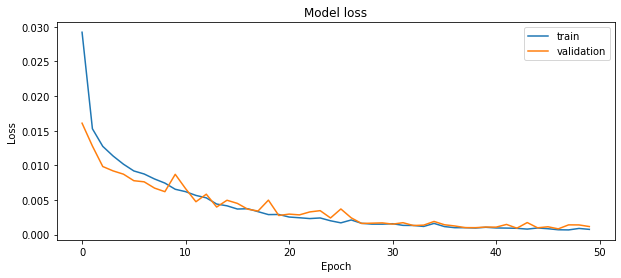

In [14]:
from utils import plot_loss_function

# realizar rutina de entrenamiento
model_history = model.fit(X_train, Y_train,
                          batch_size=128, epochs=50,
                          validation_data=(X_val, Y_val))

# plot gráfico de función de pérdida
plot_loss_function(model_history, figsize=(10,4))

## Model Evaluation

Como siempre, una vez entrenado nuestro modelo debemos evaluar su desempeño. Dado que ahora disponemos de una gran cantidad de datos, podemos evaluar correctamente el modelo frente a un conjunto `testing` que no ha visto antes. Para obtener los estimados/predicciones del RUL sobre nuevas series temporales, conviene utilizar el método `keras.Sequential.predict`, análogamente a como hemos hecho en las arquitecturas anteriores.

Por otro lado, dado que estamos frente a un problema de regresión no podemos utilizar las herramientas de visualización anteriores como la matriz de consfusión. En este caso utilizaremos un `scatter plot` medainte la función `utils.plot_predict_scatter` para visualizar la correlación entre las predicciones `Y_pred` y los valores reales `Y_true`.

testing rmse: 0.133


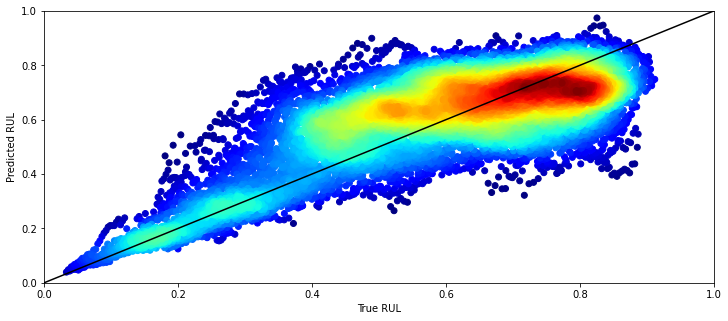

In [15]:
from utils import plot_predict_scatter

# obtener predicciones de X_test del modelo
Y_pred = model.predict( X_test )

# obtener valores RUL reales del X_test
Y_true = Y_test

# calcular el rmse de las predicciones.
rmse = np.sqrt( np.mean( np.power( Y_pred - Y_true, 2 ), axis=None ) )
print('testing rmse: {:1.3f}'.format(rmse))

# plot de matriz de confusión
plot_predict_scatter(Y_true, Y_pred)